<font size="+2"><p style="text-align: center;"><b> Auswertung Versuch 233 PAP 2.1. </p></font>

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

In [4]:
plt.rc('lines', linewidth = 0.8, marker = '.', markersize = 3, markeredgewidth = 0.4)
plt.rc('errorbar', capsize = 2, )

In [5]:
def linear(x, a, b):
    return a*x + b

def linear_inv(y, a, b):
    return (y - b)/a

In [6]:
def beugung_spalt(x):
    return np.sinc(x)**2

In [7]:
def beugung_doppelspalt(x, _g, _d):
    return beugung_spalt(x) * np.cos(np.pi*_g/_d*x)**2

In [8]:
# Ablesefehler der Positionsmessungen (in px):
px_error = 2

# Brennweite von L1 in mm
f1 = 80

# Wellenlänge des Lasers in mm
lamb = 635e-6

# Breite eines Pixels in mm:
pxbreite = 14e-3

## 3.1 Quantitative Beobachtungen am Einfachspalt

### Eichung der Abszisse

Zunächst bestimmen wir, wieviel Pixel auf der Kamera 1 mm in der Fourierebene entsprechen. Dazu wurde zu Beginn des Versuchs der Analysierspalt in der Fourierebene auf drei verschiedene Weiten eingestellt und die zugehörigen Abstände in Pixel auf dem Monitor abgelesen.

In [12]:
# Breiten in der Fourierebene (d.h. Öffnung des Analysierspalts)
x_fourier = np.array([1.1, 0.79, 0.615])*2
Dx_fourier = 0.01*2

# Breiten auf Kamera:
x_kamera = np.array([1427.3, 1341.19, 1286.73]) - np.array([642.82, 719.19, 785.69])
x_kamera_error = np.sqrt(2)*10
print(x_kamera)

[784.48 622.   501.04]


In [13]:
popt, pcov = curve_fit(lambda x, m: m*x, x_fourier, x_kamera, sigma = np.repeat(x_kamera_error, 3))
conv_factor = popt[0]
conv_factor_error = np.sqrt(pcov[0][0])
print('Abstand Kamera / Abstand Fourierebene = ', conv_factor, ' +- ', conv_factor_error, ' px/mm')

('Abstand Kamera / Abstand Fourierebene = ', 375.72409126680304, ' +- ', 15.203048208024626, ' px/mm')


Somit entspricht ein Abstand von 1mm des Analysierspalts etwa $357.7 \pm 12.2$ Pixel auf dem Monitor

Text(0.5,1,'Diagramm 20: Eichung der Abszisse')

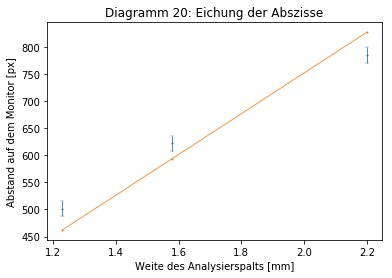

In [22]:
plt.errorbar(x_fourier, x_kamera, yerr = x_kamera_error, linestyle = 'none')
plt.plot(x_fourier, conv_factor*x_fourier)
plt.xlabel('Weite des Analysierspalts [mm]')
plt.ylabel('Abstand auf dem Monitor [px]')
plt.title('Diagramm 20: Eichung der Abszisse')

## Berechnung der Spaltweite

In [23]:
# Position der Minima in px
minima = np.array([953.34, 875.24, 798.87, 720.77, 642.67])
maxima = np.array([1029.71, 918.63, 837.06, 760.69, 682.59, 602.75])
n_minima = np.arange(1, 6)

Die Minima liegen für kleine Winkel $\alpha$ bei
$$n \cdot \lambda = d \cdot \sin(\alpha) \approx d \cdot \frac{x_\text{fourier}}{f_1}$$
d.h.
$$d \approx \lambda f_1 \cdot \frac{n}{x_\text{fourier}}$$

In [25]:
popt, pcov = curve_fit(linear, n_minima, minima, sigma = np.repeat(px_error, 5))
steigung = -popt[0]/conv_factor # Umrechnung von Pixel in mm
steigung_error = steigung*np.sqrt((np.sqrt(pcov[0][0])/popt[0])**2 + (conv_factor_error/conv_factor)**2)

In [26]:
d = lamb*f1/steigung
d_error = d*steigung_error/steigung
print('Spaltbreite: d = ', d, ' +- ', d_error, ' mm')

('Spaltbreite: d = ', 0.2460239470426583, ' +- ', 0.009970053958427937, ' mm')


In [27]:
n_maxima = linear_inv(maxima, *popt)
print(n_maxima)
n_maxima_error = n_maxima * np.sqrt((np.sqrt(pcov[0][0])/popt[0])**2 + (Dpx/maxima)**2)
print(Dn_maxima)

[0.01560949 1.44740336 2.49882059 3.4832111  4.48990088 5.51901883]


NameError: name 'Dpx' is not defined

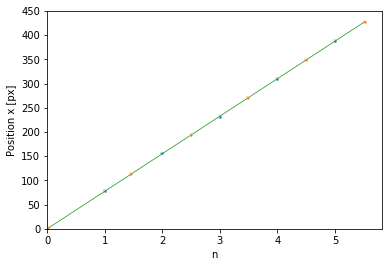

In [40]:
plt.errorbar(n_minima, popt[1] - minima, yerr = px_error, linestyle = 'none')
plt.errorbar(n_maxima, popt[1] - maxima, xerr = n_maxima_error, linestyle = 'none')
plt.plot(n_maxima, popt[1] - linear(n_maxima, *popt), marker = '')
plt.xlabel('n')
plt.ylabel('Position x [px]')
plt.ylim(bottom = 0)
plt.xlim(left = 0)
plt.savefig('fig/minima_maxima_pos.pdf')

In [15]:
# Numerische Bestimmung der theoretischen Maxima:
x = np.linspace(-6, 0.1, 10000)
intens_theo = beugung_spalt(x)
maxima_indices, maxima_prop = find_peaks(intens_theo, height = 0)
print(maxima_prop['peak_heights'])
nebenmaxima_theo = np.flip(maxima_prop['peak_heights'][:-1])
print(np.flip(-x[maxima_indices]))

[0.00336073 0.00502872 0.00834029 0.01648002 0.04719042 0.99999999]
[5.00050005e-05 1.43003300e+00 2.45920592e+00 3.47068707e+00
 4.47728773e+00 5.48144814e+00]


## Intensitäten

In [16]:
untergrund_1 = np.mean([125, 132])
untergrund_2 = np.mean([191, 148])
verhaeltnis = (3513 - untergrund_1)/(315.8 - untergrund_2)

intens = (np.array([3513, 1550, 897.7, 579.2, 412]) - untergrund_2) / verhaeltnis / (3719 - untergrund_1)
Dintens = 0.02*intens

In [17]:
print(intens)
print(nebenmaxima_theo)
# Abweichung in sigma:
print((intens - nebenmaxima_theo) / Dintens)

[0.04025281 0.01662001 0.00876689 0.00493243 0.00291949]
[0.04719042 0.01648002 0.00834029 0.00502872 0.00336073]
[-8.61754342  0.4211479   2.43302124 -0.97608124 -7.55684194]


# Aufgabe 4

## Maße des Doppelspalts

In [18]:
# Bildweite in mm:
b = 633
Db = 5

# Gegenstandsweite
g_weite  = 1/(1/f1 + 1/b)
Dg_weite = 1/(1/f1 + 1/b)**2 * 1/b**2 * Db

# Vergrößerung von Objekt zu Bildebene:
vergroesserung = b/g_weite # = 1 + b/f1
Dvergroesserung = Db/f1

In [19]:
# Spaltabstand mitte-mitte in px:
g_px = np.mean([794.9, 916.8]) - np.mean([508.0, 630.9])

# Für Spaltbreite Mittelwert aus beiden Spaltbreiten:
d2_px = np.mean([630.9 - 508.0, 916.8 - 794.9])

Dg_px = np.sqrt(2)*5
Dd2_px = np.sqrt(2)*5

In [20]:
g = g_px*pxbreite/vergroesserung
Dg = g*np.sqrt((Dg_px/g_px)**2 + (Dvergroesserung/vergroesserung)**2)

d2 = d2_px*pxbreite/vergroesserung
Dd2 = d*np.sqrt((Dd2_px/d2_px)**2 + (Dvergroesserung/vergroesserung)**2)

print('Spaltabstand: g = ', g, ' +- ', Dg, ' mm')
print('Spaltbreite: d = ', d2, ' +- ', Dd2, ' mm')

Spaltabstand: g =  0.449884992987377  +-  0.011546782162032  mm
Spaltbreite: d =  0.19226928471248242  +-  0.014384219113103162  mm


## Berechnung der theoretischen Bilder

In [21]:
def doppelspalt(k, y):
    return d2/np.pi * np.sin(k*d2/2)/(k*d2/2) * np.cos(k*y) * np.cos(k*g/2)

In [22]:
Y_ = np.linspace(-2, 2, 200)*d2
f_mod_ = np.empty((3, len(Y_)))

for n in range(1, 4):
    for i, y in enumerate(Y_):
        result, error = quad(lambda k: doppelspalt(k, y), 0, 2*np.pi*n/d2)
        f_mod_[n - 1, i] = result**2
# Normieren auf Maximum 0-ter Ordnung:
max_0_ = np.max(f_mod_[0])
for n in range(1, 4):
    f_mod_[n - 1] = f_mod_[n - 1]/max_0_

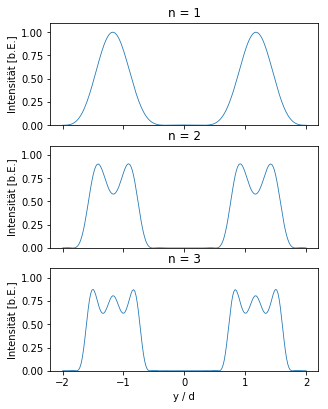

In [23]:
fig, ax = plt.subplots(3, 1, sharex = True, figsize = (4.8, 6.4))
for n in range(1, 4):
    ax[n - 1].plot(Y_/d2, f_mod_[n - 1], marker = '')
    ax[n - 1].set_ylim((0, 1.1))
    if n == 3:
        ax[n - 1].set_xlabel('y / d')
    ax[n - 1].set_ylabel('Intensität [b.E.]')
    ax[n - 1].set_title('n = %i' % n)
plt.savefig('fig/doppelspalt_mod.pdf')

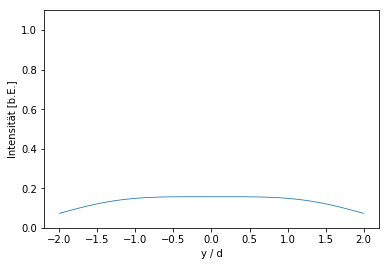

In [24]:
# Fall b):
f_mod_b = np.empty(Y_.size)
k_y_theo = 0.67 * 2*np.pi/g
for i, y in enumerate(Y_):
    result, error = quad(lambda k: doppelspalt(k, y), 0, k_y_theo)
    f_mod_b[i] = result**2/max_0_
    
plt.plot(Y_/d2, f_mod_b, marker = '')
plt.ylim((0, 1.1))
plt.xlabel('y / d')
plt.ylabel('Intensität [b.E.]')
plt.savefig('fig/fall_b.pdf')

In [25]:
k_y_a = 2*np.pi/lamb * 0.31/f1
Dk_y_a = k_y_a*0.01/0.31
print('Fall a):')
print('Experimentell: ', k_y_a, ' +- ', Dk_y_a, ' 1/mm')
print('Theoretisch: ', 2*np.pi/d2)
print('Abweichung: ', (k_y_a - 2*np.pi/d2)/Dk_y_a)

k_y_b = 2*np.pi/lamb * 0.14/f1
Dk_y_b = k_y_b*0.01/0.14
print('Fall b):')
print('Experimentell: ', k_y_b, ' +- ', Dk_y_b, ' 1/mm')
print('Theoretisch: ', k_y_theo, ' 1/mm')
print('Abweichung: ', (k_y_b - k_y_theo)/Dk_y_b)

Fall a):
Experimentell:  38.342272543812435  +-  1.2368475014133042  1/mm
Theoretisch:  32.679090248738376
Abweichung:  4.578723155929029
Fall b):
Experimentell:  17.315865019786266  +-  1.2368475014133047  1/mm
Theoretisch:  9.357356260888748  1/mm
Abweichung:  6.434510923782918


# Aufgabe 2

## Berechnung der Beugungsbilder

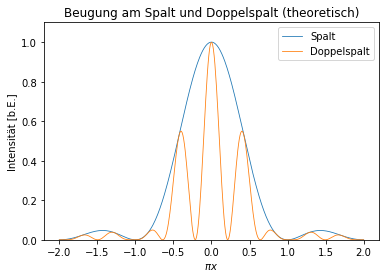

In [26]:
# Anzahl zu zeigender Nebenmaxima:
a = 1

x2 = np.linspace(-(a + 1), a + 1, 400)
intens_theo2 = beugung_doppelspalt(x2, g, d2)

plt.plot(x2, beugung_spalt(x2), label = 'Spalt', marker = '')
plt.plot(x2, intens_theo2, label = 'Doppelspalt', marker = '')
plt.xlabel('$\pi x$')
plt.ylabel('Intensität [b.E.]')
plt.ylim((0, 1.1))
plt.legend()
plt.title('Beugung am Spalt und Doppelspalt (theoretisch)')
plt.savefig('fig/beugung_spalt_doppelspalt.pdf')

In [27]:
# Numerische Bestimmung der theoretischen Maxima:
maxima_indices2, maxima_prop2 = find_peaks(intens_theo2, height = 0.04)
print(maxima_prop2['peak_heights'])
nebenmaxima_theo2 = np.flip(maxima_prop2['peak_heights'][:2])

[0.04934042 0.54927492 0.99856039 0.54927492 0.04934042]


[0.09726049 0.61427975 0.99824982 0.61427975 0.09726049]
[0.11834661 0.97121326]


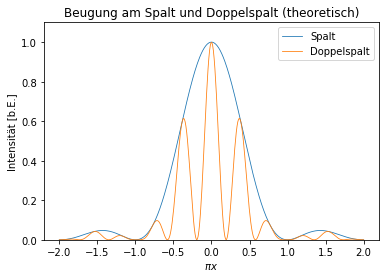

In [28]:
# Durch Einsetzen anderer Werte für d und g Unsicherheit der theoretischen Werte bestimmen:
intens_theo2_test = beugung_doppelspalt(x2, g + Dg, d2 - Dd2)

plt.plot(x2, beugung_spalt(x2), label = 'Spalt', marker = '')
plt.plot(x2, intens_theo2_test, label = 'Doppelspalt', marker = '')
plt.xlabel('$\pi x$')
plt.ylabel('Intensität [b.E.]')
plt.ylim((0, 1.1))
plt.legend()
plt.title('Beugung am Spalt und Doppelspalt (theoretisch)')

maxima_indices2_test, maxima_prop2_test = find_peaks(intens_theo2_test, height = 0.05)
print(maxima_prop2_test['peak_heights'])
nebenmaxima_theo2_test = np.flip(maxima_prop2_test['peak_heights'][:2])
Dnebenmaxima_theo2 = np.abs(nebenmaxima_theo2 - nebenmaxima_theo2_test)
print(Dnebenmaxima_theo2/nebenmaxima_theo2)

## Vergleich mit Messwerten

In [29]:
untergrund = np.mean([136, 134])

intens2 = (np.array([2261, 360.6]) - untergrund) / (3554 - untergrund)
Dintens2 = 0.02*intens2

In [30]:
print(intens2)
print(Dintens2)
print(nebenmaxima_theo2)
print(Dnebenmaxima_theo2)
# Abweichung in sigma:
print((intens2 - nebenmaxima_theo2) / np.sqrt(Dintens2**2 + Dnebenmaxima_theo2**2))

[0.62181925 0.06598421]
[0.01243638 0.00131968]
[0.54927492 0.04934042]
[0.06500483 0.04792007]
[1.09610447 0.34719228]


# Aufgabe 3

## Bestimmung der Spaltbreite

In [31]:
# Spaltbreite in px:
d_alt_kamera = 1013.5 - 891.6
Dd_alt_kamera = np.sqrt(2)*5

d_alt = d_alt_kamera*pxbreite/vergroesserung
Dd_alt = d_alt*np.sqrt((Dd_alt_kamera/d_alt_kamera)**2 + (Dvergroesserung/vergroesserung)**2)
print('Spaltbreite Einzelspalt: d = ', d_alt, ' +- ', Dd_alt, ' mm')

diff = d_alt - d
print('Abweichung zu erster Messung: ', diff/np.sqrt(Dd_alt**2 + Dd**2), ' sigma')

Spaltbreite Einzelspalt: d =  0.19148387096774186  +-  0.011188300722417183  mm
Abweichung zu erster Messung:  -0.7781091012516531  sigma


## Vergleich mit theoretischen Bildern

In [32]:
def spalt(k, y):
    return d_alt/np.pi * np.sin(k*d_alt/2)/(k*d_alt/2) * np.cos(k*y)

In [33]:
# Integrationsbereich: bis zum n-ten Minimum
Y = np.linspace(-1, 1, 3200)*d_alt
f_mod = np.empty((3, len(Y)))

for n in range(1, 4):
    for i, y in enumerate(Y):
        result, error = quad(lambda k: spalt(k, y), 0, 2*np.pi*n/d_alt)
        f_mod[n - 1, i] = result**2
# Normieren auf Maximum 0-ter Ordnung:
max_0 = np.max(f_mod[0])
for n in range(1, 4):
    f_mod[n - 1] = f_mod[n - 1]/max_0

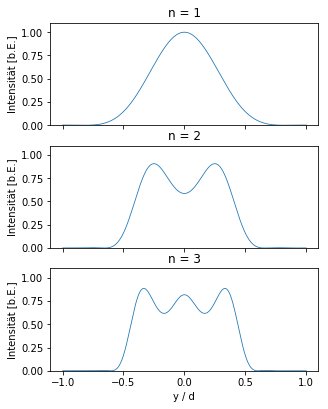

In [34]:
fig, ax = plt.subplots(3, 1, sharex = True, figsize = (4.8, 6.4))
for n in range(1, 4):
    ax[n - 1].plot(Y/d_alt, f_mod[n - 1], marker = '')
    ax[n - 1].set_ylim((0, 1.1))
    if n == 3:
        ax[n - 1].set_xlabel('y / d')
    ax[n - 1].set_ylabel('Intensität [b.E.]')
    ax[n - 1].set_title('n = %i' % n)
plt.savefig('fig/spalt_mod.pdf')

In [35]:
# Abstände zwischen Maxima in y/d:
# n = 2:
dist_max_2 = (985.5 - 924.7)/d_alt_kamera
Ddist_max_2 = dist_max_2 * np.sqrt((np.sqrt(2)*5/(985.5 - 924.7))**2 + (Dd_alt_kamera/d_alt_kamera)**2)
# n = 3:
dist_max_3 = np.diff([913.6, 954.1, 996.4])/d_alt_kamera
Ddist_max_3 = dist_max_3 * np.sqrt((np.sqrt(2)*5/np.diff([913.6, 954.1, 996.4]))**2 + (Dd_alt_kamera/d_alt_kamera)**2)

In [36]:
# Peaks der theoretischen Bilder:
# n = 2
peaks_theo_2, max_heights_2 = find_peaks(f_mod[1], height = 0.5)
# n = 3
peaks_theo_3, max_heights_3 = find_peaks(f_mod[2], height = 0.5)
max_heights_2 = max_heights_2['peak_heights']
max_heights_3 = max_heights_3['peak_heights']

# Abstände der peaks:
dist_theo_2 = np.diff(peaks_theo_2)/1600 # 3200 Punkte auf [-1, 1]
dist_theo_3 = np.diff(peaks_theo_3)/1600

In [37]:
print('n = 2 (gemessen): ', dist_max_2)
print('      (theoretisch): ', dist_theo_2)
print('      Abweichung: ', (dist_max_2 - dist_theo_2)/Ddist_max_2)
print('n = 3 (gemessen): ', dist_max_3)
print('      (theoretisch): ', dist_theo_3)
print('      Abweichung: ', (dist_max_3 - dist_theo_3)/Ddist_max_3)

n = 2 (gemessen):  0.49876948318293657
      (theoretisch):  [0.499375]
      Abweichung:  [-0.00934122]
n = 3 (gemessen):  [0.33223954 0.34700574]
      (theoretisch):  [0.333125 0.33375 ]
      Abweichung:  [-0.01448608  0.21589058]


In [38]:
# Intensitäten der Maxima und Minima:
untergrund_1 = np.mean([154, 158])
untergrund_2 = np.mean([142, 143])
untergrund_3 = np.mean([144, 144])

intens_max_2 = (np.array([3042, 3108]) - untergrund_2) / (3247 - untergrund_1)
intens_min_2 = (2282 - untergrund_2) / (3247 - untergrund_1)
intens_max_3 = (np.array([2939, 2922, 3110]) - untergrund_3) / (3247 - untergrund_1)
intens_min_3 = (np.array([2350, 2318]) - untergrund_3) / (3247 - untergrund_1)

In [39]:
# Bestimmung der theoretischen Minima
mins_theo_2, min_heights_2 = find_peaks(-f_mod[1], height = (-1, -0.5))
mins_theo_3, min_heights_3 = find_peaks(-f_mod[2], height = (-1, -0.5))
min_heights_2 = -min_heights_2['peak_heights']
min_heights_3 = -min_heights_3['peak_heights']

In [40]:
print('n = 2:')
print('Maxima (gemessen): ', intens_max_2)
print('       (theoretisch): ', max_heights_2)
print('       Abweichung: ', (intens_max_2 - max_heights_2)/(0.02*intens_max_2))
print('Minima (gemessen): ', intens_min_2)
print('       (theoretisch): ', min_heights_2)
print('       Abweichung: ', (intens_min_2 - min_heights_2)/(0.02*intens_min_2))

print('n = 3:')
print('Maxima (gemessen): ', intens_max_3)
print('       (theoretisch): ', max_heights_3)
print('       Abweichung: ', (intens_max_3 - max_heights_3)/(0.02*intens_max_3))
print('Minima (gemessen): ', intens_min_3)
print('       (theoretisch): ', min_heights_3)
print('       Abweichung: ', (intens_min_3 - min_heights_3)/(0.02*intens_min_3))

n = 2:
Maxima (gemessen):  [0.93804594 0.95939825]
       (theoretisch):  [0.90661762 0.90661762]
       Abweichung:  [1.67520164 2.75071561]
Minima (gemessen):  0.6921708185053381
       (theoretisch):  [0.58639992]
       Abweichung:  [7.64051991]
n = 3:
Maxima (gemessen):  [0.90423811 0.89873827 0.95956001]
       (theoretisch):  [0.88576281 0.81781107 0.88576281]
       Abweichung:  [1.02159488 4.50226766 3.84536672]
Minima (gemessen):  [0.71368489 0.70333225]
       (theoretisch):  [0.61740086 0.61740086]
       Abweichung:  [6.74555638 6.10887644]


## Äquidistanz bei hoher Ordnung

In [41]:
maxima_pos = np.array([895.2, 905.1, 915.0, 926.4, 936.0, 945.4, 955.7, 966.2, 975.9, 986.5, 997.7, 1007.4])
minima_pos = np.array([900.0, 910.2, 920.8, 929.0, 940.7, 950.8, 960.9, 972.0, 982.5, 991.6, 1002.2])
maxima_diff = np.diff(maxima_pos)
minima_diff = np.diff(minima_pos)
print(maxima_diff)
print(minima_diff)
print('Standardabweichung Maximaabstand: ', np.std(maxima_diff))
print('Standardabweichung Minimaabstand: ', np.std(minima_diff))

[ 9.9  9.9 11.4  9.6  9.4 10.3 10.5  9.7 10.6 11.2  9.7]
[10.2 10.6  8.2 11.7 10.1 10.1 11.1 10.5  9.1 10.6]
Standardabweichung Maximaabstand:  0.6310164959665001
Standardabweichung Minimaabstand:  0.9325234581499761


In [42]:
all_pos = np.empty(maxima_pos.size + minima_pos.size)
all_pos[0::2] = maxima_pos
all_pos[1::2] = minima_pos
all_diff = np.diff(all_pos)
print(all_diff)
print('Standardabweichung aller Abstände: ', np.std(all_diff))

[4.8 5.1 5.1 4.8 5.8 5.6 2.6 7.  4.7 4.7 5.4 4.9 5.2 5.3 5.8 3.9 6.6 4.
 5.1 6.1 4.5 5.2]
Standardabweichung aller Abstände:  0.905538513813741


(array([1., 0., 1., 1., 5., 6., 3., 3., 0., 2.]),
 array([2.6 , 3.04, 3.48, 3.92, 4.36, 4.8 , 5.24, 5.68, 6.12, 6.56, 7.  ]),
 <a list of 10 Patch objects>)

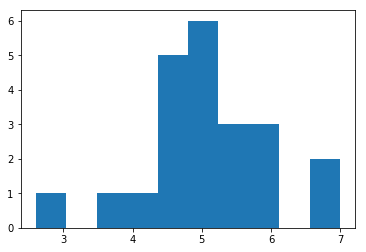

In [43]:
plt.hist(all_diff)